SemForms automatically mines code from large GitHub repositories of existing code that may be operating on the same dataset to construct features for AutoML.

<center><img src=https://github.com/wala/graph4code/blob/master/semForms/automl_eval/semforms.png width="680" align="center"/></center>
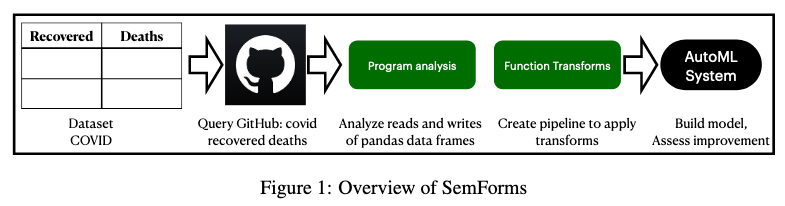

In [1]:
from semforms import *
from sklearn.datasets import fetch_openml
from auto_example import handle_transforms
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import statistics
from sklearn.pipeline import Pipeline
import requests
import json
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


### 1. Select Dataset and Estimator (Classification/Regression)

In [2]:
#Consider the housing dataset from OpenML as an example.
dataset_name = 'houses'
problem_type = 'regression'

# dataset_name = 'BNG(heart-h,nominal,1000000)'
# problem_type = 'classification'


In [3]:
%%capture
dataset      = fetch_openml(dataset_name, version=1, as_frame=True, parser="pandas") # name is dataset_name
X            = dataset['data']
target       = dataset['target'].to_frame()
X = encode_categorial(X)

### 2. Dataset Understanding

In [4]:
print('Columns:', X.columns)
# print('Target:', target)
print('Target:', dataset['target_names'])

Columns: Index(['median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms',
       'population', 'households', 'latitude', 'longitude'],
      dtype='object')
Target: ['median_house_value']


### 3. ML model for the original dataset

We use a random forest regressor on this dataset to find a baseline R^2 value.

In [5]:
# Set standard classifier (could be any AutoML as well)
if problem_type == 'regression':
    estimator = RandomForestRegressor(random_state = 1908)
    metric = 'r2'
else:
    estimator = RandomForestClassifier(random_state = 1908)
    metric = 'balanced_accuracy'
    
# Evaluate on original data
scores = cross_val_score(estimator, X, numpy.ravel(target), cv=3, scoring=metric)
print(f"Averaged {metric} score on original data:  " + str(statistics.mean(scores)))

Averaged r2 score on original data:  0.5814812832363954


### 4. SemFORMS: Transforms Recommendation

#### 4.1. Search for relevant transforms 

To find relevant scripts, we can use the GitHub API to find Python notebooks that have mentions of the table name and columns.

In [7]:
urls = search_github(dataset_name, dataset_cols=X.columns)
expressions = mine_code_for_expressions(urls)

query:houses median_income housing_median_age total_rooms total_bedrooms population households latitude longitude


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.22it/s]


In [8]:
print('Recommended Expressions:')
expr_name_to_code = {}
for exp in expressions:
    print('\t', exp['code'])
    expr_name_to_code[exp['expr_name']] = exp['code']


Recommended Expressions:
	 lambda df: (float (df[ 'median_income' ]))
	 lambda df: (float (df[ 'latitude' ]))
	 lambda df: (df[ 'median_income' ])
	 lambda df: (df[ 'latitude' ])
	 lambda df: (float (df[ 'longitude' ]))
	 lambda df: (df[ 'longitude' ])
	 lambda df: (df[ 'population' ] / df[ 'households' ])
	 lambda df: (df[ 'total_bedrooms' ] / df[ 'total_rooms' ])
	 lambda df: (df[ 'total_rooms' ] / df[ 'households' ])
	 lambda df: (df[ 'population' ] > 10000)


#### 4.2. Filter out irrelevant transforms 

In [9]:
%%capture
# Analyze given transforms and if applicable create SKLEARN Function Transforms as a pipeline
transforms_suggested, correlation = handle_transforms("both", expressions, target, X)

In [10]:
print('Filtered Expressions:')
pretty_print_transforms(transforms_suggested, expr_name_to_code)

Filtered Expressions:
	lambda df: (df[ 'population' ] / df[ 'households' ])
	lambda df: (df[ 'total_bedrooms' ] / df[ 'total_rooms' ])
	lambda df: (df[ 'total_rooms' ] / df[ 'households' ])
	lambda df: (df[ 'population' ] > 10000)


#### 4.3 Testing Recommended Transforms

In [11]:
# Add estimator to suggested transformation pipeline
transforms_suggested.append(('estimator', estimator))
pipeline = Pipeline(transforms_suggested)

In [12]:
# Evaluate with data augmentation added as function transformers based on original data
scores = cross_val_score(pipeline, X, numpy.ravel(target), cv=3, scoring=metric)
print(f"Averaged {metric} score with augmentations on original data:  " + str(statistics.mean(scores)))

Averaged r2 score with augmentations on original data:  0.6552672352787577
